## Prepare imports

In [1]:
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Batch,Data

from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE

from models.encoder_sparse import BaseModel as EctEncoder

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn



from datasets.mnist import DataModule, DataModuleConfig
from layers.ect import EctLayer, EctConfig

from layers.directions import generate_directions

DEVICE = "cuda:0"
ECT_PLOT_CONFIG = {"cmap":"bone","vmin":-0.5,"vmax":1.5}
PC_PLOT_CONFIG = {"s":10,"c":'.5'}
encoder_config = OmegaConf.load("./configs/config_encoder_mnist.yaml")
vae_config = OmegaConf.load("./configs/config_vae_mnist.yaml")

## Load Models and Data

In [2]:
from datasets import load_datamodule


layer = EctLayer(
    EctConfig(
        num_thetas=encoder_config.layer.ect_size,
        bump_steps=encoder_config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_directions(encoder_config.layer.ect_size,encoder_config.layer.dim, DEVICE),
)

dm = load_datamodule(encoder_config.data)

# vae_model = VanillaVAE(in_channels=vae_config.model.in_channels, latent_dim=vae_config.model.latent_dim,img_size=vae_config.layer.ect_size)

# # Load the VAE model

# metrics = get_mse_metrics()

# vae_litmodel = BaseVAE.load_from_checkpoint(
#     f"./trained_models/{vae_config.model.save_name}",
#     model=vae_model,
#     training_accuracy=metrics[0],
#     test_accuracy=metrics[1],
#     validation_accuracy=metrics[2],
#     accuracies_fn=compute_mse_accuracies,
#     loss_fn=compute_mse_loss_fn,
#     learning_rate=0.01,
#     layer=layer,
# ).to(DEVICE)


# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/{encoder_config.model.save_name}",
    layer=layer,
    ect_size=encoder_config.layer.ect_size,
    hidden_size=encoder_config.model.hidden_size,
    num_pts=encoder_config.model.num_pts,
    num_dims=encoder_config.model.num_dims,
    learning_rate=encoder_config.model.learning_rate,
).to(DEVICE)


C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.2.3


In [3]:
data_list = []
for idx in range(10):
    data_list.extend(dm.test_ds[dm.test_ds.y==idx][:1])

batch = Batch.from_data_list(data_list).to(DEVICE)

In [4]:
ect_encoder_litmodel.model

Model(
  (conv): Sequential(
    (0): Conv1d(1, 128, kernel_size=(128,), stride=(128,))
    (1): ReLU()
  )
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
  )
)

In [5]:
# ect = layer(batch,batch.batch)
# ect_flat = ect.squeeze().flatten(start_dim=1)

# w1 = ect_encoder_litmodel.model[1].weight.detach().cpu().numpy()
# b1 = ect_encoder_litmodel.model[1].bias

# w1.shape

# plt.plot(w1[:30].T)



In [6]:
# import torch.nn.functional as F

# l1 = F.linear(ect_flate,w1,b1)
# print(prelin.shape)

In [7]:
# plt.plot(ect_flat[0].cpu().detach().squeeze())

In [8]:
# for j in range(10):
#     out = ect_conv[j].max(axis=-2)[0].detach().cpu().numpy()
#     plt.plot(out)



In [9]:
# prelin = ect_conv.max(axis=-2)[0]
# w1 = ect_encoder_litmodel.model.layer[1].weight
# b1 = ect_encoder_litmodel.model.layer[1].bias
# w3 = ect_encoder_litmodel.model.layer[3].weight
# b3 = ect_encoder_litmodel.model.layer[3].bias
# import torch.nn.functional as F

# l1 = F.linear(prelin,w1,b1)
# print(prelin.shape)
# print(w1.shape)

In [10]:

# plt.plot(l1[0].detach().cpu().numpy())

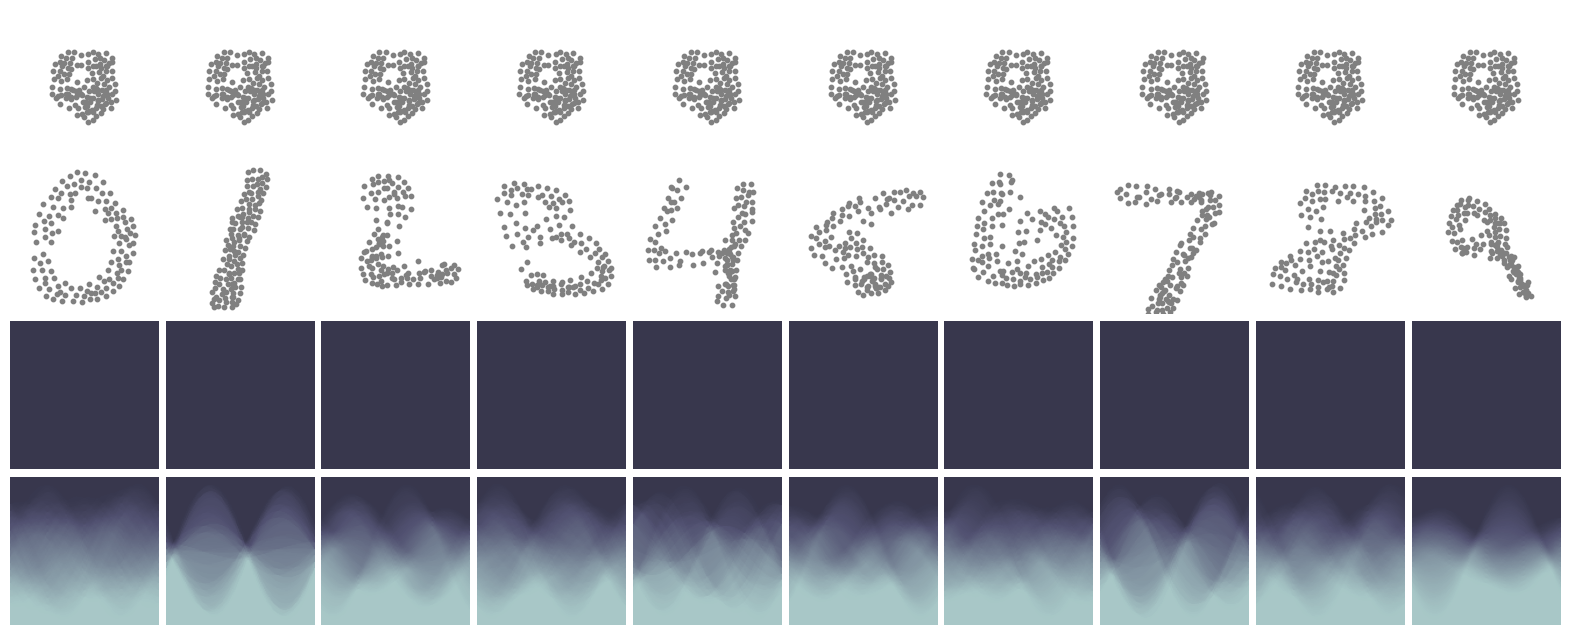

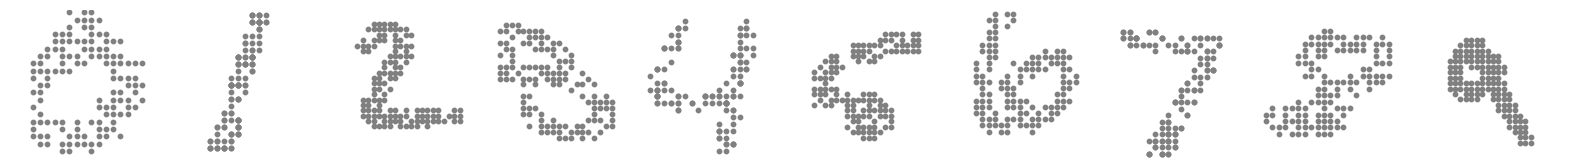

In [11]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)



ect = layer(batch,batch.batch).unsqueeze(1)

# with torch.no_grad():
#     decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# # Undo the VAE transform
# decoded = (decoded + 1 ) / 2

decoded = torch.zeros_like(ect)

with torch.no_grad():
    recon_vae_batch = ect_encoder_litmodel.model.forward(decoded.squeeze())
    recon_batch = ect_encoder_litmodel.model.forward(ect.squeeze().movedim(-1,-2))


fig, axes = plt.subplots(
    nrows=4, ncols=10, figsize=(20,8)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)
    


for orig_pts, recon_pts, recon_vae_pts,orig_img, recon_img,axis in zip(batch.x.view(-1,128,2),recon_batch,recon_vae_batch,ect,decoded,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = orig_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_vae_pts = recon_vae_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = rotate(orig_pts, degrees=-90)
    recon_pts = rotate(recon_pts, degrees=-90)
    recon_vae_pts = rotate(recon_vae_pts, degrees=-90)

    ax = axis[0]
    ax.scatter(recon_vae_pts[:,0],recon_vae_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")


    # ax = axis[1]
    # ax.scatter(orig_pts[:,0],orig_pts[:,1],**PC_PLOT_CONFIG)
    # ax.set_xlim([-1,1])
    # ax.set_ylim([-1,1])
    # ax.set_aspect(1)
    # ax.axis("off")

    ax = axis[1]
    ax.scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")

    ax = axis[2]
    ax.imshow(recon_img.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
    ax.axis("off")

    ax = axis[3]
    ax.imshow(orig_img.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
    ax.axis("off")    

plt.savefig("./figures/img/mnist/reconstructed_mnist.svg",transparent=True)   



fig, axes = plt.subplots(
    nrows=1, ncols=10, figsize=(20,8)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)


for orig_pts, recon_pts, recon_vae_pts,orig_img, recon_img,axis in zip(batch.x.view(-1,128,2),recon_batch,recon_vae_batch,ect,decoded,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = orig_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_vae_pts = recon_vae_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = rotate(orig_pts, degrees=-90)
    recon_pts = rotate(recon_pts, degrees=-90)
    recon_vae_pts = rotate(recon_vae_pts, degrees=-90)


    ax = axis
    ax.scatter(orig_pts[:,0],orig_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")

plt.savefig("./figures/img/mnist/mnist_base_pointclouds.svg",transparent=True)   


In [12]:
ect_encoder_litmodel.model

Model(
  (conv): Sequential(
    (0): Conv1d(1, 128, kernel_size=(128,), stride=(128,))
    (1): ReLU()
  )
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
  )
)

In [13]:
w1 = ect_encoder_litmodel.model[1].weight.detach().cpu().numpy()
b1 = ect_encoder_litmodel.model[1].bias.detach().cpu().numpy()
w1.shape

TypeError: 'Model' object is not subscriptable

In [ ]:
512*4096

2097152

(512, 4096)


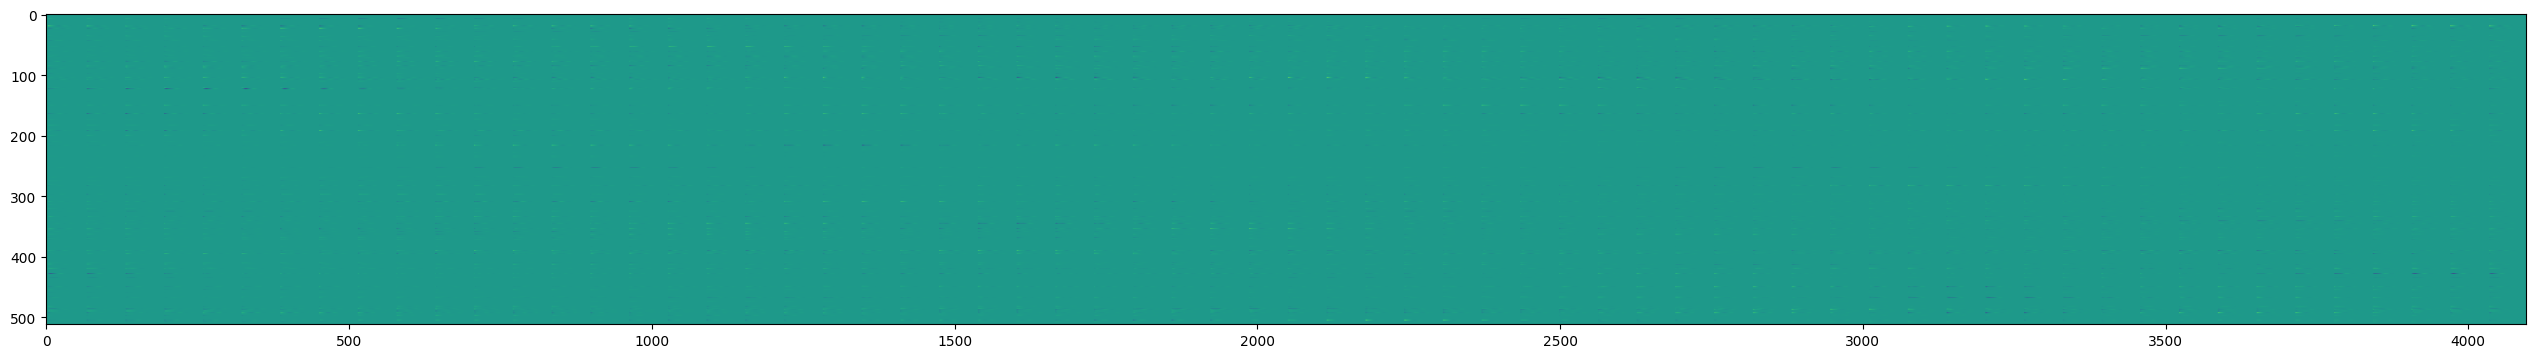

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(32,8))
print(w1.shape)
ax.imshow(w1)

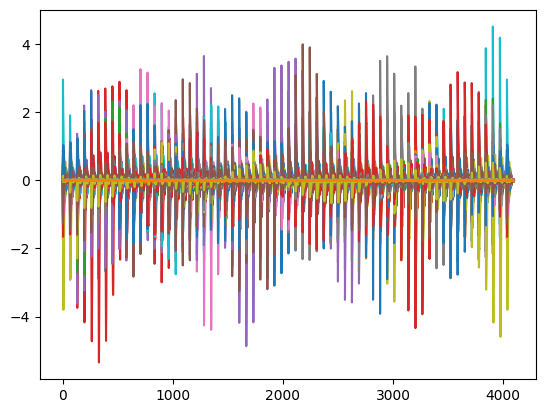

In [ ]:
p = w1
plt.plot(p.T)

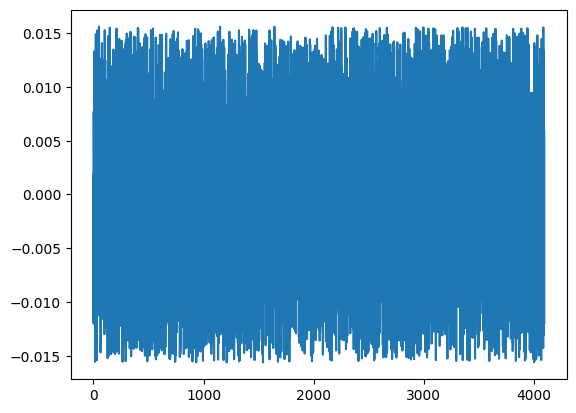

In [ ]:
plt.plot(p.T[:,2])

576


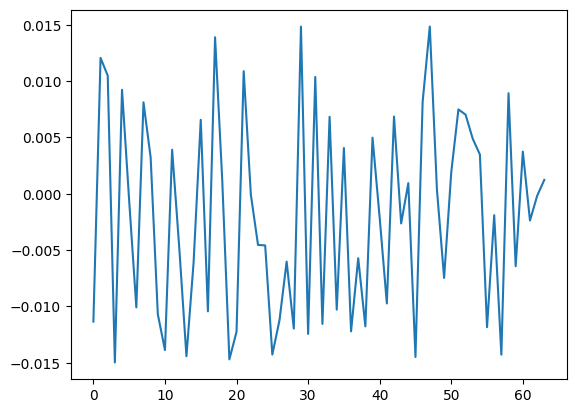

In [ ]:
CHUNK = 9
print(64*CHUNK)
plt.plot(p.T[64*CHUNK:64*(CHUNK+1),2])

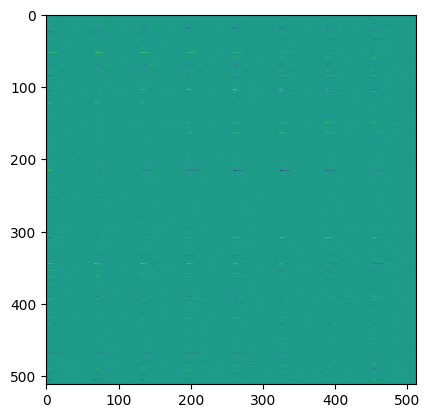

In [ ]:
plt.imshow(w1[:,1024:(1024+512)])

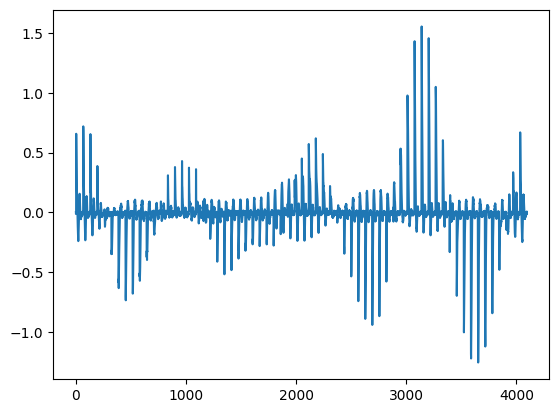

In [ ]:


plt.plot(w1[20])

In [ ]:
ect_encoder_litmodel.model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=512, bias=True)
  (6): ReLU()
  (7): Linear(in_features=512, out_features=256, bias=True)
)

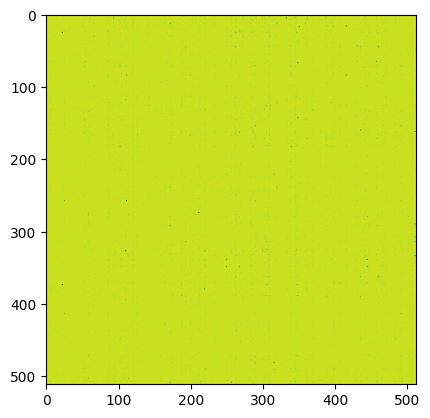

In [ ]:

w2 = ect_encoder_litmodel.model[5].weight.detach().cpu().numpy()
plt.imshow(w2)

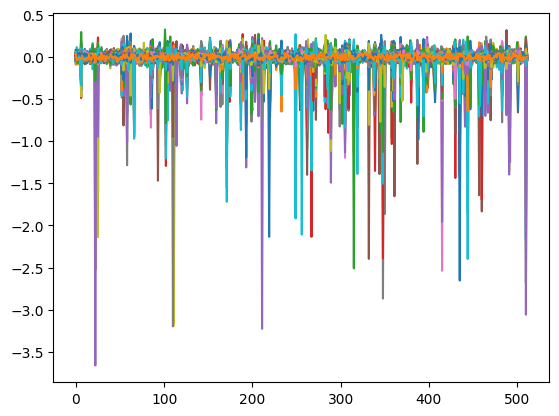

In [ ]:
plt.plot(w2.T)

In [ ]:
from torch import nn
flatter = nn.Sequential(nn.Flatten())



In [ ]:
w1 = ect_encoder_litmodel.model[1].weight.detach().cpu()
b1 = ect_encoder_litmodel.model[1].bias.detach().cpu()

outs = torch.zeros(size=(52,),dtype=torch.bool)

for i in range(10):
    e = flatter(ect.movedim(-1,-2))[i].cpu()
    res = torch.nn.functional.relu(w1@e+b1)
    outs = outs | (res>0)
    plt.plot(res)

RuntimeError: The size of tensor a (52) must match the size of tensor b (512) at non-singleton dimension 0

In [ ]:
outs.sum()

tensor(20)

In [ ]:
r = torch.abs(w1)>.4
(r.sum(axis=1) > 10 ).sum()

tensor(77)